In [2]:
#############################
# This code is to plot the supplementary figures for paper4
# 2024.8.21 first written, updated 2024.9.20
# Mu-Ting Chien
################################

In [3]:
import os
import sys
sys.path.append('/glade/work/muting/function/')
import KW_diagnostics as KW
import create_my_colormap as mycolor
RWB = mycolor.red_white_blue()
#import mjo_mean_state_diagnostics as MJO
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap # for plotting KW composite vertical structure

/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [43]:
dir_out = '/glade/work/muting/KW/'
CASENAME_LIST2 = list(['SST_AQP3_Qobs_27_-4K',\
                       'SST_AQP3_Qobs_27',\
                       'SST_AQP3_Qobs_27_4K'])
CASENAME_SHORT_LIST = list(['-4K','CTL','4K'])
#figdir            = dir_out+'figure/Post_general/Paper4/Supplementary/' # Original directory
figdir            = dir_out+'figure/Post_general/Paper4_20240822/Supplement/' # Updated directory
#output_dir_all    = dir_out+'output_data/Paper4/' # Original directory
output_dir_all     = dir_out+'output_data/Paper4_20240822/' # updated directory
os.makedirs(figdir,exist_ok=True) 

pi = np.pi
bin_simple = np.arange(-pi,pi+1/4*pi,1/4*pi)
PI = '\u03C0'
s2d = 86400

In [29]:
normalize_by_kwamp = 1 # 0 or 1

# Load KW amplitude (from max and min of KW precip)
if normalize_by_kwamp == 1:
    data = np.load(output_dir_all+'KW_amplitude_pr_all.npz')
    kwamp_all = data['kwamp_all']
else:
    kwamp_all = 1

# Load KW precip and other 2D variables
data         = np.load(output_dir_all+'KW_composite_2D_all.npz')
pr_KW_all    = data['pr_KW_all']

save_DCIN = 1 # 0 (saving) or 1 (already saved)
if save_DCIN == 0:

    # Load other 2D variables
    data         = np.load(output_dir_all+'KW_composite_2D_all.npz')
    LH_KW_all    = data['LH_KW_all']
    u1000_KW_all = data['u1000_KW_all']
    q1000_KW_all = data['q1000_KW_all']
    phase        = data['phase']

    for icase in range(0,3):
        # Load DCIN
        CASENAME = CASENAME_LIST2[icase]+'_3h_20y'
        CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_20y_3h_20y'
        output_dir = dir_out+'output_data/'+CASENAME+'/'
        #data = np.load(output_dir+'kw_composite_SF_DCIN_byMSE_3yr_freqused.npz')
        data = np.load(output_dir+'kw_composite_DCIN_byMSE_3yr_new_freqused_single_level.npz')
        phase = data['phase']
        nphase = np.size(phase)
        if icase == 0:
            DCIN_KW_all = np.empty([nphase, 3])
        DCIN_KW_all[:,icase] = data['DCIN_mse_kw']

    # Save DCIN
    np.savez(output_dir_all+'KW_composite_2D_all.npz', pr_KW_all=pr_KW_all, LH_KW_all=LH_KW_all,\
                 u1000_KW_all=u1000_KW_all, q1000_KW_all=q1000_KW_all, DCIN_KW_all=DCIN_KW_all, phase=phase)
else:
    data = np.load(output_dir_all+'KW_composite_2D_all.npz')
    DCIN_KW_all = data['DCIN_KW_all']

# Load EOF
data  = np.load(output_dir_all+'EOF_all.npz')
EOFQ1 = data['EOFQ1'][2:-2,:]
EOFQ2 = data['EOFQ2'][2:-2,:]
plev_eof  = data['plev'][2:-2]
nlev_eof  = np.size(plev_eof)

# Load T_KW
data = np.load(output_dir_all+'KW_composite_3D_all.npz')
T_KW_all = data['T_KW_all']/kwamp_all
q_KW_all = data['q_KW_all']/kwamp_all

# Load T2_KW
for icase in range(0,3):
    tmp1, tmp2 = KW.vertical_mode_decomposition(T_KW_all[:,:,icase], EOFQ1[:,icase], EOFQ2[:,icase])
    if icase == 0:
        T1_KW_all = np.empty([nphase, nlev_eof, 3])
        T2_KW_all = np.empty([nphase, nlev_eof, 3])
    T1_KW_all[:,:,icase] = tmp1
    T2_KW_all[:,:,icase] = tmp2

# Average over lf
ilev_lf_min = np.argwhere(plev==750).squeeze()
ilev_lf_max = np.argwhere(plev==850).squeeze()
qlf_KW_all  = np.mean(q_KW_all[:,ilev_lf_min:ilev_lf_max+1,:], 1)
T2lf_KW_all = np.mean(T2_KW_all[:,ilev_lf_min:ilev_lf_max+1,:], 1)

In [7]:
##########################################################################
# Calculate cross spectrum between (1) Q1 and Q2, (2) T2 and Q1, and (3) Q2 and T2
################################################################################
save_coh2 = 1 # 0 (saving) or 1 (already saved)

if save_coh2 == 0:
    for icase in range(0,3):
        print(icase)
        if icase != 1:
            CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new'
        else:
            CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new_uv_tendency'
        CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_CLUBB_new'
        output_dir     = dir_out+'output_data/'+CASENAME+'/'
        
        # Load Q, T anomaly
        data    = np.load(output_dir+'QTUVZq.npz') # Note that this data is after meridional projection! you need to load raw anomaly
        time    = data['time']
        lon     = data['lon']
        nt      = np.size(time)
        nlon    = np.size(lon)
        plev    = data['plev'][2:-2]
        Qproj   = data['Qproj'][:,2:-2,:]
        Tproj   = data['Tproj'][:,2:-2,:]
        Qm      = np.mean(np.mean(Qproj,2),0)
        Tm      = np.mean(np.mean(Tproj,2),0)
        
        Qm_big  = np.tile(Qm,(nt, nlon,1))
        Qm_big  = np.transpose(Qm_big, (0, 2,1))
        Qa      = Qproj-Qm_big
        Qa      = np.transpose(Qa, (0,2,1))
        del Qm_big, Qproj, Qm
    
        Tm_big  = np.tile(Tm,(nt, nlon,1))
        Tm_big  = np.transpose(Tm_big, (0, 2,1))
        Ta      = Tproj-Tm_big
        Ta      = np.transpose(Ta, (0,2,1))
        del Tm_big, Tproj, Tm
    
        # Calculate PCQ, PCT
        PCQ1 = np.inner(Qa, EOFQ1[:,icase])
        PCQ2 = np.inner(Qa, EOFQ2[:,icase])
        PCT1 = np.inner(Ta, EOFQ1[:,icase])
        PCT2 = np.inner(Ta, EOFQ2[:,icase])
        del Qa, Ta
    
        # To obtain size of wavenum and freq
        tmp, tmp2, tmp3, tmp4, x, y, freq, zwnum = KW.calculate_coh2_spectrum(PCQ1, PCQ2)
        del tmp, tmp2, tmp3, tmp4
        n0 = np.size(x,0)
        n1 = np.size(x,1)
        
        if icase == 0:
            coh_PCQ1_PCQ2_all = np.empty([n0,n1,3])
            sin_PCQ1_PCQ2_all = np.empty([n0,n1,3])
            cos_PCQ1_PCQ2_all = np.empty([n0,n1,3])
            #
            coh_PCQ1_PCT2_all = np.empty([n0,n1,3])
            sin_PCQ1_PCT2_all = np.empty([n0,n1,3])
            cos_PCQ1_PCT2_all = np.empty([n0,n1,3])
            #
            coh_PCQ2_PCT2_all = np.empty([n0,n1,3])
            sin_PCQ2_PCT2_all = np.empty([n0,n1,3])
            cos_PCQ2_PCT2_all = np.empty([n0,n1,3])
            
        # Calculate coh^2
        coh_PCQ1_PCQ2_all[:,:,icase], sin_PCQ1_PCQ2_all[:,:,icase], cos_PCQ1_PCQ2_all[:,:,icase], \
                coh_crit, x, y, freq, zwnum = KW.calculate_coh2_spectrum(PCQ2, PCQ1)
        coh_PCQ1_PCT2_all[:,:,icase], sin_PCQ1_PCT2_all[:,:,icase], cos_PCQ1_PCT2_all[:,:,icase], \
                coh_crit, x, y, freq, zwnum = KW.calculate_coh2_spectrum(PCT2, PCQ1)
        coh_PCQ2_PCT2_all[:,:,icase], sin_PCQ2_PCT2_all[:,:,icase], cos_PCQ2_PCT2_all[:,:,icase], \
                coh_crit, x, y, freq, zwnum = KW.calculate_coh2_spectrum(PCT2, PCQ2)   
    
    np.savez(output_dir_all+'coh2_spectrum.npz',\
                        coh_PCQ1_PCQ2_all=coh_PCQ1_PCQ2_all, \
                         sin_PCQ1_PCQ2_all=sin_PCQ1_PCQ2_all,\
                         cos_PCQ1_PCQ2_all=cos_PCQ1_PCQ2_all,\
                        coh_PCQ1_PCT2_all=coh_PCQ1_PCT2_all, \
                         sin_PCQ1_PCT2_all=sin_PCQ1_PCT2_all,\
                         cos_PCQ1_PCT2_all=cos_PCQ1_PCT2_all,\
                        coh_PCQ2_PCT2_all=coh_PCQ2_PCT2_all, \
                         sin_PCQ2_PCT2_all=sin_PCQ2_PCT2_all,\
                         cos_PCQ2_PCT2_all=cos_PCQ2_PCT2_all,\
                        x=x, y=y, freq=freq, zwnum=zwnum, coh_crit=coh_crit)

else: # Load coh^2
    data = np.load(output_dir_all+'coh2_spectrum.npz')
    coh_PCQ1_PCQ2_all = data['coh_PCQ1_PCQ2_all']
    sin_PCQ1_PCQ2_all = data['sin_PCQ1_PCQ2_all']
    cos_PCQ1_PCQ2_all = data['cos_PCQ1_PCQ2_all']
    coh_PCQ1_PCT2_all = data['coh_PCQ1_PCT2_all']
    sin_PCQ1_PCT2_all = data['sin_PCQ1_PCT2_all']
    cos_PCQ1_PCT2_all = data['cos_PCQ1_PCT2_all']
    coh_PCQ2_PCT2_all = data['coh_PCQ2_PCT2_all']
    sin_PCQ2_PCT2_all = data['sin_PCQ2_PCT2_all']
    cos_PCQ2_PCT2_all = data['cos_PCQ2_PCT2_all']    
    x                 = data['x']
    y                 = data['y']
    freq              = data['freq']
    zwnum             = data['zwnum']
    coh_crit          = data['coh_crit']

In [32]:
# Load KW composite DTdt decomposition, used for Fig. S5
save_kw_dTdt = 1 # 0 (saving) or 1 (already saved)
if save_kw_dTdt == 0:
    
    for icase in range(0,3):
        #
        if icase != 1:
            CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new'
        else:
            CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new_uv_tendency'
        output_dir = dir_out+'output_data/'+CASENAME+'/'
        #
        data           = np.load(output_dir+'dTdt_each_term_kwcomposite.npz')
        plev           = data['plev']
        phase          = data['phase']
        nlev           = np.size(plev)
        nphase         = np.size(phase)
        if icase == 0:
            DTCOND_KW      = np.empty([nphase, nlev, 3])
            ZMDT_KW        = np.empty([nphase, nlev, 3])
            EVAPTZM_KW     = np.empty([nphase, nlev, 3])
            ZMMTT_KW       = np.empty([nphase, nlev, 3])
            STEND_CLUBB_KW = np.empty([nphase, nlev, 3])
            MPDT_KW        = np.empty([nphase, nlev, 3])
            
        DTCOND_KW[:,:,icase]      = data['DTCOND_KW'][:,:]*s2d
        ZMDT_KW[:,:,icase]        = data['ZMDT_KW'][:,:]*s2d
        EVAPTZM_KW[:,:,icase]     = data['EVAPTZM_KW'][:,:]*s2d
        ZMMTT_KW[:,:,icase]       = data['ZMMTT_KW'][:,:]*s2d
        STEND_CLUBB_KW[:,:,icase] = data['STEND_CLUBB_KW'][:,:]*s2d
        MPDT_KW[:,:,icase]        = data['MPDT_KW'][:,:]*s2d

    # Save data
    # Note that the unit is in K/day
    unit = 'K/day'
    np.savez(output_dir_all+'KW_composite_3D_all_dTdt_each_term.npz',\
             unit=unit, phase=phase, plev=plev,\
             DTCOND_KW_all = DTCOND_KW, ZMDT_KW_all=ZMDT_KW,\
             EVAPTZM_KW_all = EVAPTZM_KW, ZMMTT_KW_all=ZMMTT_KW,\
             STEND_CLUBB_KW_all = STEND_CLUBB_KW, MPDT_KW_all = MPDT_KW)

else:
    data           = np.load(output_dir_all+'KW_composite_3D_all_dTdt_each_term.npz')
    DTCOND_KW      = data['DTCOND_KW_all']
    ZMDT_KW        = data['ZMDT_KW_all']
    EVAPTZM_KW     = data['EVAPTZM_KW_all']
    ZMMTT_KW       = data['ZMMTT_KW_all']
    STEND_CLUBB_KW = data['STEND_CLUBB_KW_all']
    MPDT_KW        = data['MPDT_KW_all']
    plev           = data['plev']

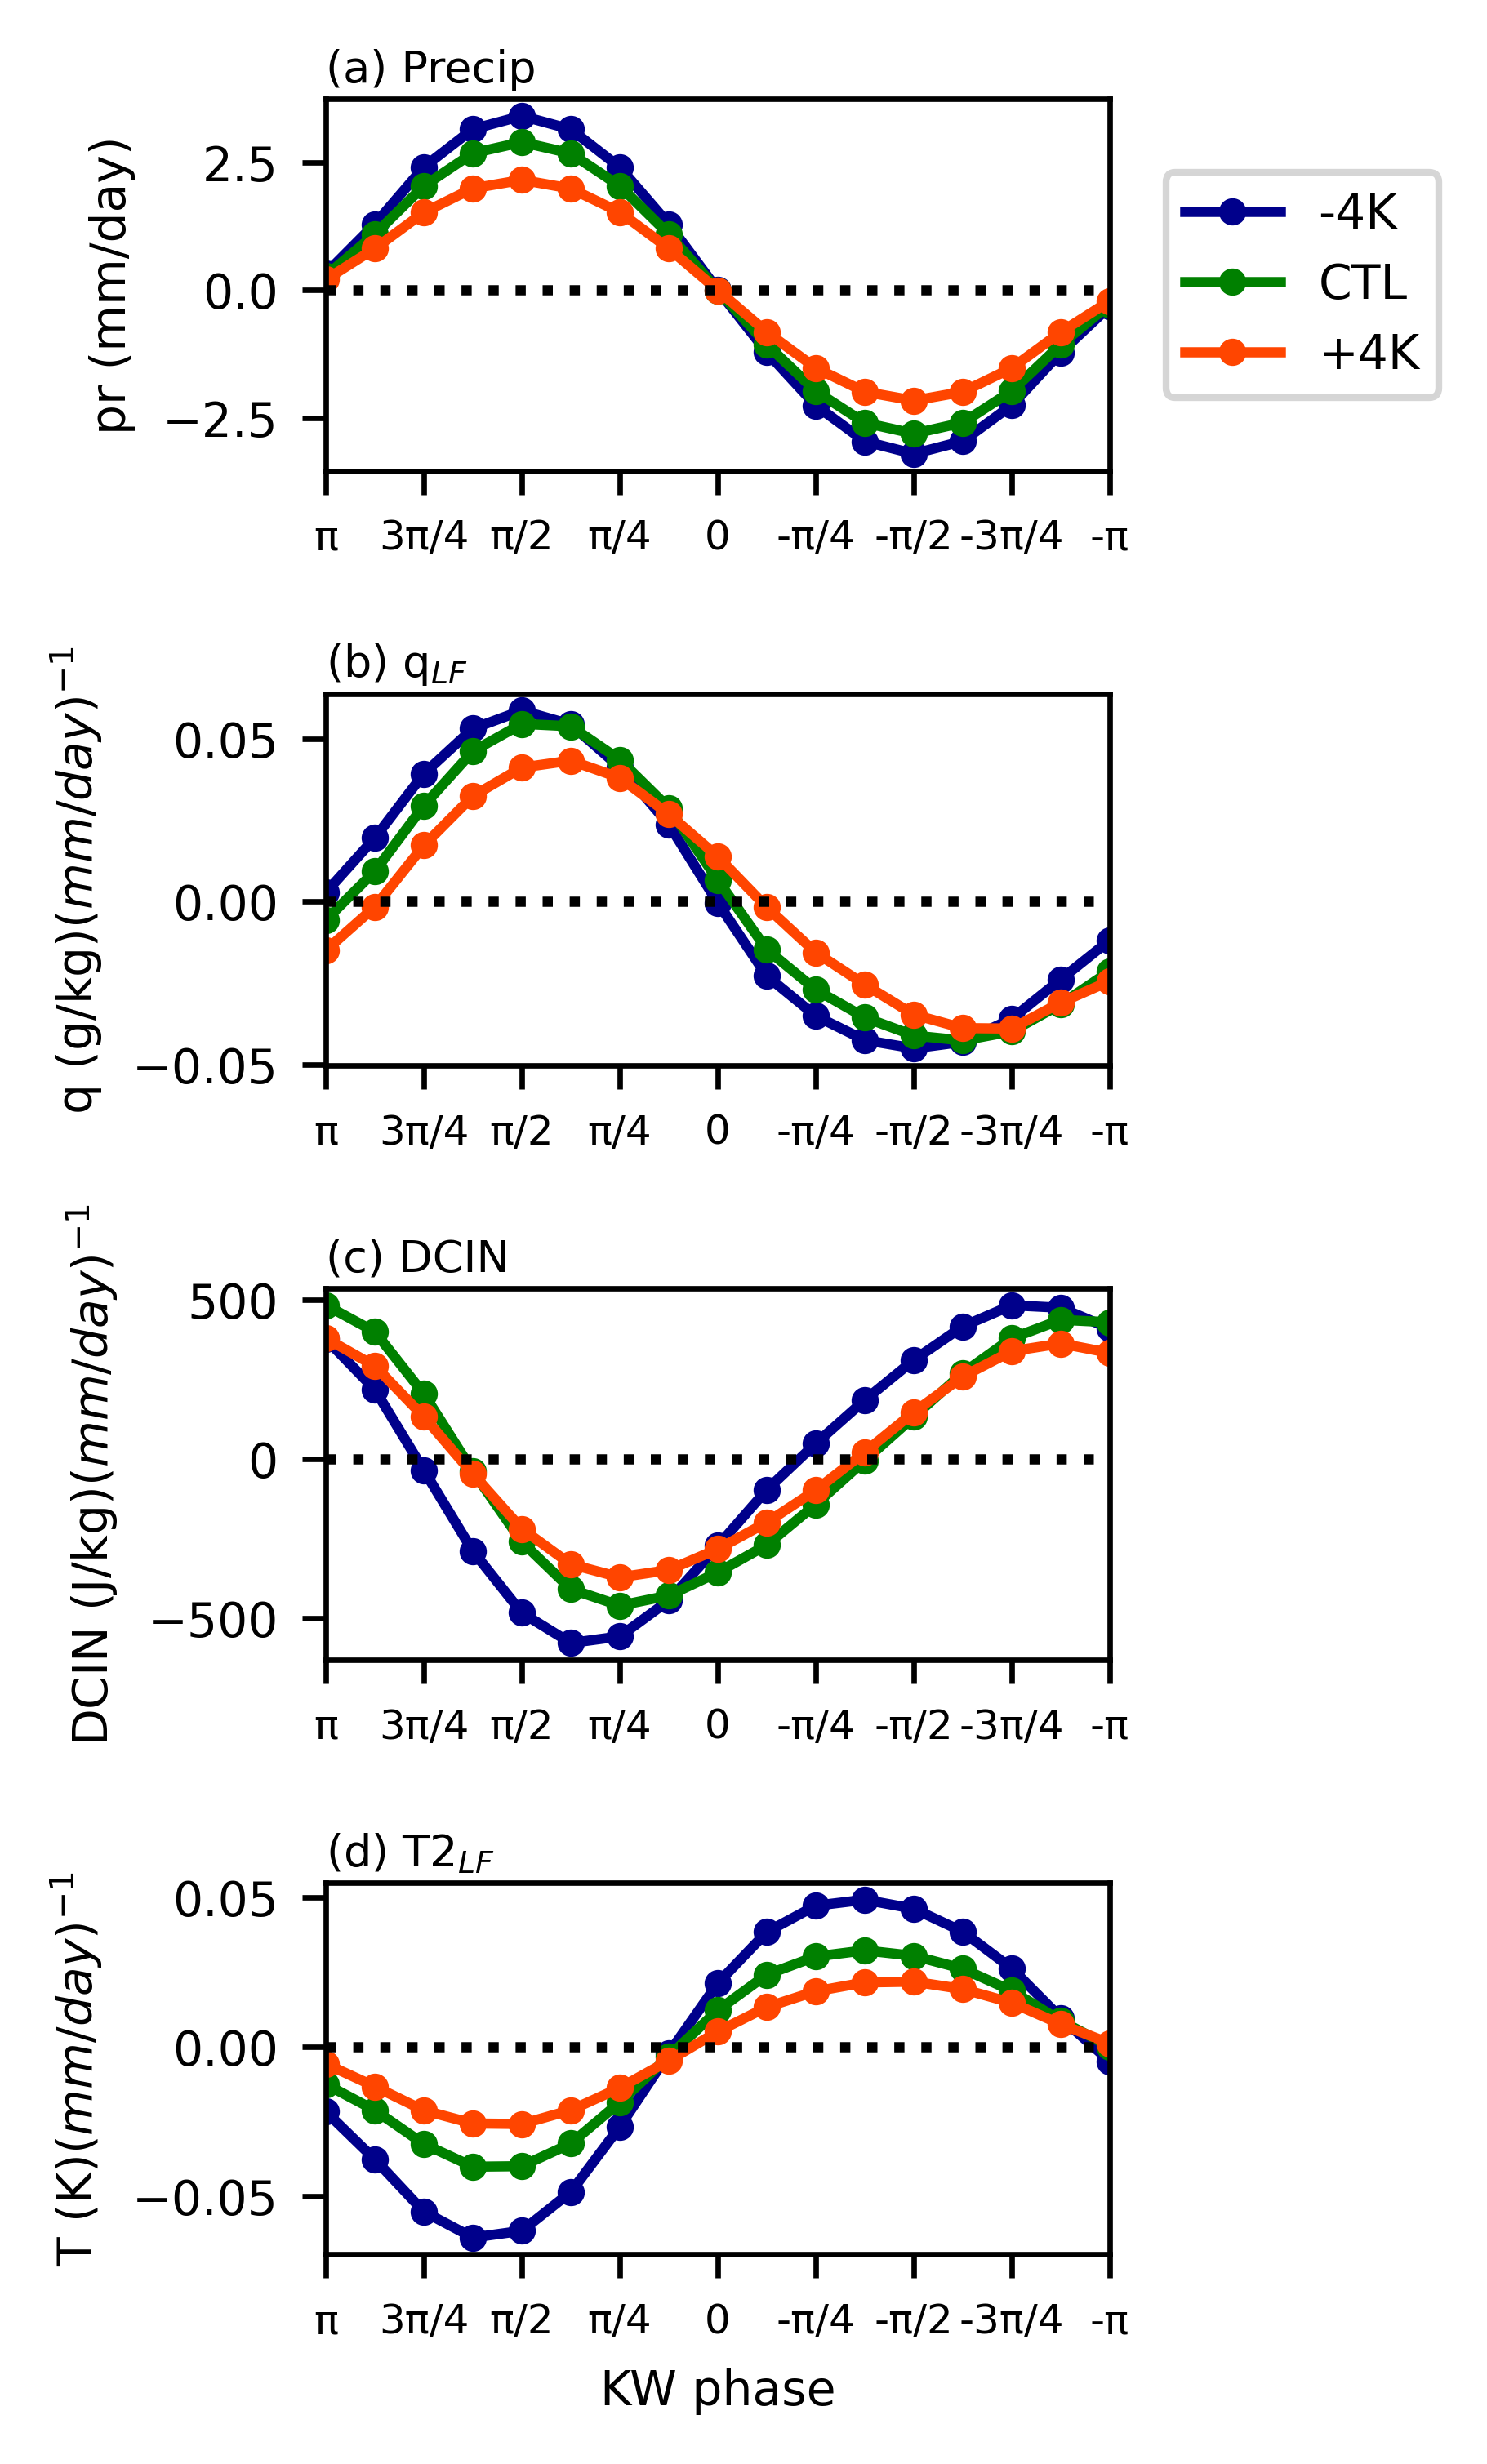

In [39]:
###################################
# Fig. S1 KW composite 2D variables (top to bottom: pr_kw, q_750_800_kw, DCIN_750_800_kw)
#################################
plt.rcParams.update({'font.size': 7})
if normalize_by_kwamp == 0:
    fig_name = 'Fig.S1_KW_composite_pr_q_DCIN_T2.png'
    ylabel_list = list(['pr (mm/day)','q (g/kg)','DCIN (J/kg)','T (K)'])
else:
    fig_name = 'Fig.S1_KW_composite_pr_q_DCIN_T2_normalized.png'
    ylabel_list = list(['pr (mm/day)','q (g/kg)$(mm/day)^{-1}$','DCIN (J/kg)$(mm/day)^{-1}$','T (K)$(mm/day)^{-1}$'])
#ymax = np.array([3.7, 0.23, 600, 0.15, 22])
#ymin = np.array([-3.7, -0.21, -600, -0.18, -22])
#
fig, axes = plt.subplots(4,1,figsize=(3.2, 5.5),dpi=600)
plt.subplots_adjust(left=0.2,right=0.7,top=0.9,bottom=0.1,hspace=0.6)
zero = np.zeros([np.size(phase)])
title_list = list(['(a) Precip','(b) q$_{LF}$','(c) DCIN','(d) T2$_{LF}$'])
vlist = list(['pr_KW_all','qlf_KW_all','DCIN_KW_all','T2lf_KW_all'])

#
for iplt in range(0,4):
    plt.subplot(4,1,iplt+1)
    ax = plt.gca()
    plt.title(title_list[iplt], pad=2.5, loc='left',fontsize=6.5)
    VAR = globals()[vlist[iplt]]
    plt.plot(phase, VAR[:,0],color='darkblue',marker='o',markersize=3)
    plt.plot(phase, VAR[:,1],color='green',marker='o',markersize=3)
    plt.plot(phase, VAR[:,2],color='orangered',marker='o',markersize=3)
    if iplt == 0:
        ax.legend(['-4K','CTL','+4K'],bbox_to_anchor=(1.45, 0.5), loc='center right',fontsize=7)
    plt.plot(phase, zero, 'k:')
    plt.ylabel(ylabel_list[iplt])
    plt.xticks(bin_simple,(PI,'3'+PI+'/4',PI+'/2',PI+'/4','0','-'+PI+'/4','-'+PI+'/2','-3'+PI+'/4','-'+PI), fontsize=6)
    plt.xlim(-np.pi,np.pi)
    #plt.ylim(ymin[iplt],ymax[iplt])
    if iplt == 3:
        plt.xlabel('KW phase')
plt.savefig(figdir+fig_name,format='png', dpi=600)
plt.show()

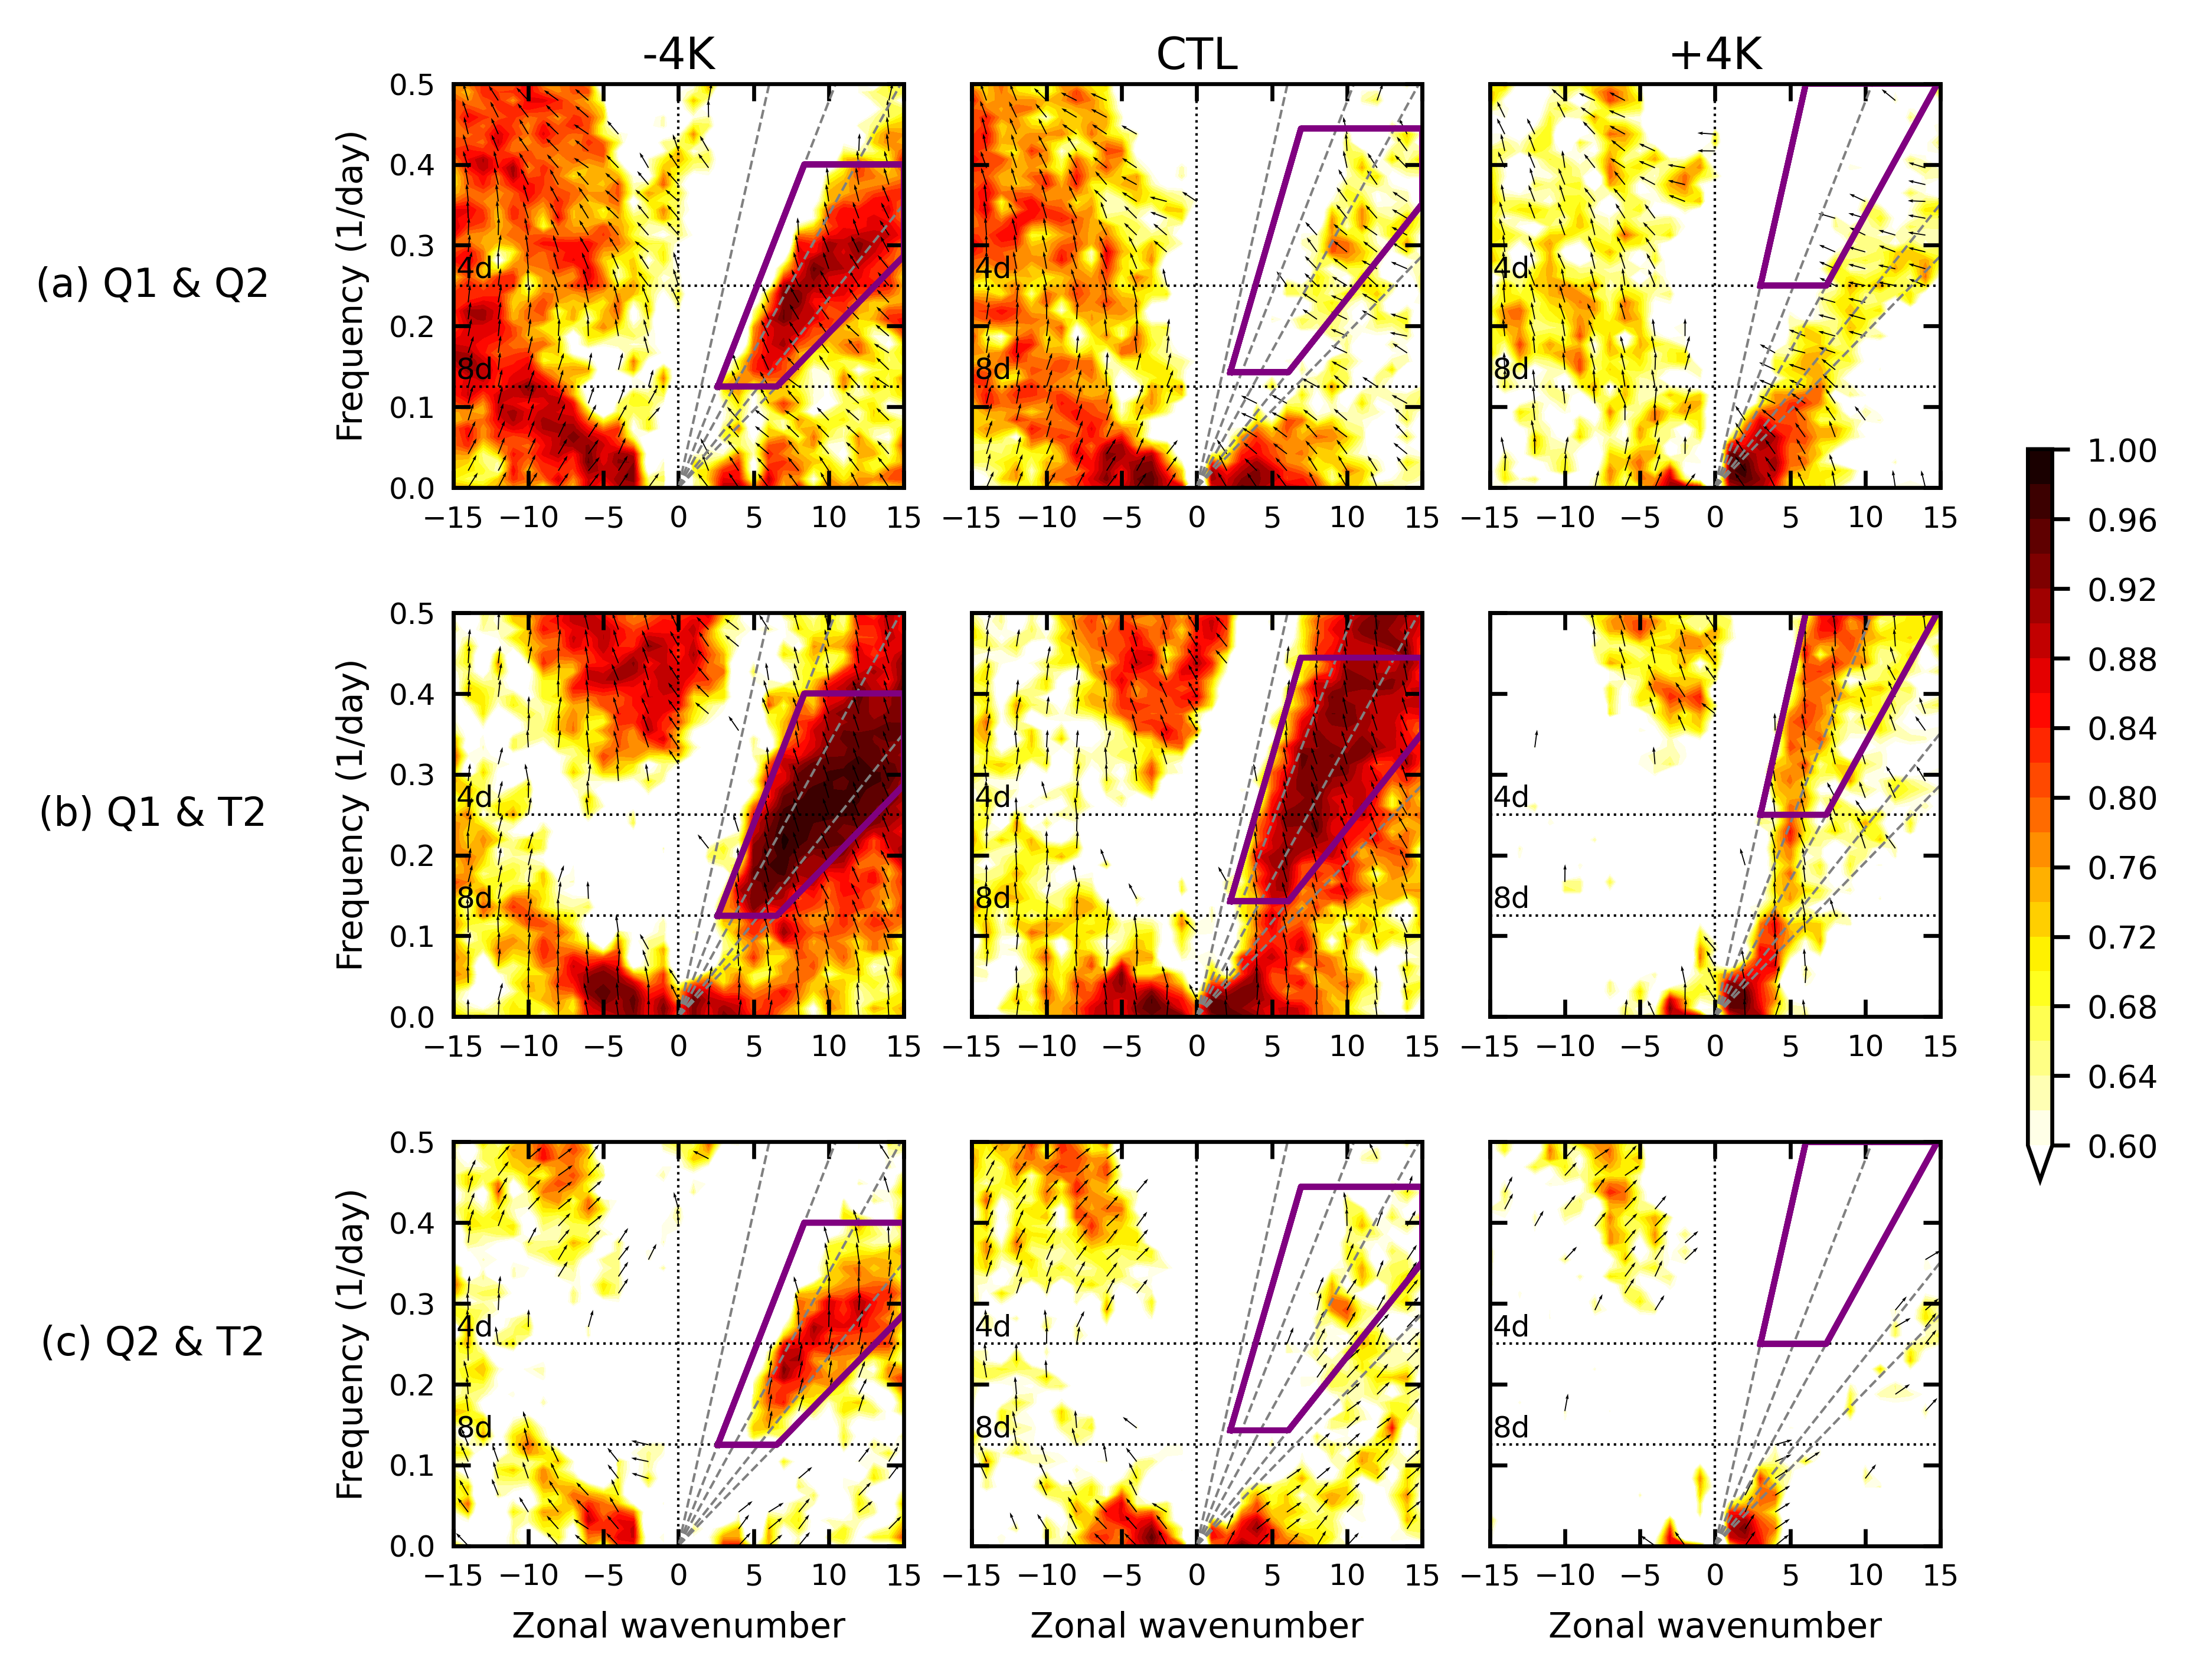

In [40]:
#########################################################
# Fig. S2: Coherence squared in wavenumber-frequency space
##########################################################
title = list(['-4K','CTL','+4K'])
vname = list(['PCQ1_PCQ2','PCQ1_PCT2','PCQ2_PCT2'])
axid = np.array([0,1,2]).astype('int')
xid = np.array([0,0,0]).astype('int')
yid = np.array([0,1,2]).astype('int')
coh_min = 0.6
g = 9.8
s2d = 86400
re = 6371*1000
txt_xloc = -35
txt_yloc = 0.25
rowname_list = list(['(a) Q1 & Q2','(b) Q1 & T2','(c) Q2 & T2'])

fig,ax = plt.subplots(3,3,figsize=(6.5, 4.8),dpi=600)
plt.subplots_adjust(left=0.22,right=0.98,top=0.95,bottom=0.09,wspace=0.15,hspace=0.31)
plt.rcParams.update({'font.size': 6.5})
figname = 'Fig.S2_coh2_Q1Q2.png'
for iplt in range(0,3):# plot coh^2 between PCQ1 and PCQ2 only    
    
    v_cf = globals() ['coh_'+vname[iplt]+'_all']
    v_sin = globals() ['sin_'+vname[iplt]+'_all']
    v_cos = globals() ['cos_'+vname[iplt]+'_all']

    v_sin_new = np.where(v_cf>=coh_min, v_sin, np.nan)
    v_cos_new = np.where(v_cf>=coh_min, v_cos, np.nan) 

    clev = np.arange(coh_min,1.02,0.02)
    ticks = np.arange(coh_min,1.04,0.04)     
    ticks = ticks[:-1]
    
    for v in range(0,3):
        plt.subplot(3,3,iplt*3+v+1)
        #####################
        # Dispersion curve and CCKW band
        d = np.array([4,8])#([3,6]) # mark 3, 6, 20 day in WK1999
        dname = list(['4d','8d'])#(['3d','6d'])
        if v == 0:
            he = np.array([8,25,50]) 
            hname = list(['8m','25m','50m'])
        elif v==1:
            he = np.array([12,25,90]) # mark equivalent depth for sym spectrum
            hname = list(['12m','25m','90m'])
        elif v == 2:
            he = np.array([25,90,150]) 
            hname = list(['25m','90m','150m'])
        he_all = np.array([8, 12, 25, 50, 150])

        # dispersion curve
        xloc = np.array([12,12,4.9])
        yloc = np.array([0.29,0.47,0.47])
        cp = (g*he_all)**0.5
        zwnum_goal = 0.5/s2d/cp*2*np.pi*re
        # CCKW band
        s_min = (g*he[0])**0.5/(2*np.pi*re)*s2d #slope of he = 8m
        s_max = (g*he[2])**0.5/(2*np.pi*re)*s2d #slope of he = 90m
        kw_tmax_list = np.array([8,7,4])
        kw_tmax = kw_tmax_list[v]
        fmax = np.array([0.4,1/2.25,0.5])
        kw_x = np.array([1/kw_tmax/s_max, 1/kw_tmax/s_min,     15,  15, fmax[v]/s_max, 1/kw_tmax/s_max])
        kw_y = np.array([1/kw_tmax,             1/kw_tmax,  15*s_min, fmax[v],      fmax[v],  1/kw_tmax])
        #ax[yid[v]] = plt.subplot(1,3,axid[v]+1)
        
        # plot coh2 and sin, cos
        cf = plt.contourf(x, y, v_cf[:,:,v], cmap='hot_r', levels = clev, extend='min') 
        
        # Mark 3, 6, 20 day period:
        for dd in range(0,np.size(d)):
            plt.plot([-15,15], [1/d[dd],1/d[dd]], 'k',linewidth=0.5, linestyle=':')#'dashed')
            plt.text(-14.8,1/d[dd]+0.01,dname[dd], fontsize=6)
        # Mark CCKW dispersion relationship:
        for hh in range(0,np.size(he_all)):
            plt.plot([0,zwnum_goal[hh]],[0,0.5],'grey',linewidth=0.5,linestyle='dashed')#,linestyle='dashed')#linestyle=':')#linestyle=(0,(5,5)))            
        # Mark zwnum == 0:
        plt.plot([0,0],[0,0.5],'k',linewidth=0.5,linestyle=':')#'dashed')
        # Mark CCKW band:
        # y=s*x
        for kk in range(0,np.size(kw_x)):
            plt.plot(kw_x,kw_y,'purple',linewidth=1.2,linestyle='solid')
        if iplt == 0:
            plt.title(title[v], pad=3, loc='center',fontsize=9)
        if v == 0:
            plt.ylabel('Frequency (1/day)',fontsize=7)
        if iplt == 2:
            plt.xlabel('Zonal wavenumber',fontsize=7)
        plt.axis([-15,15,0,0.5])
        plt.xticks([-15,-10,-5,0,5,10,15],fontsize=6)
        plt.yticks(np.arange(0,0.6,0.1),fontsize=6)
        plt.tick_params(bottom=True,top=True,left=True,right=True)
        if v == 0:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
            plt.text(txt_xloc,txt_yloc,rowname_list[iplt],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        else:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        plt.tick_params(direction="in")

        plt.quiver(zwnum[::2],freq[::2],v_sin_new[::2,::2,v],v_cos_new[::2,::2,v],units='inches',scale=20)

cb = fig.colorbar(cf,ax=ax[:],orientation = 'vertical',shrink=.5,\
                    fraction=0.1, aspect=30, pad=0.05)
cb.ax.tick_params(labelsize=6.5)
cb.set_ticks(ticks)  
plt.savefig(figdir+figname,format='png', dpi=600)
plt.show()
plt.close()                                

/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.
/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: No contour levels were found within the data range.


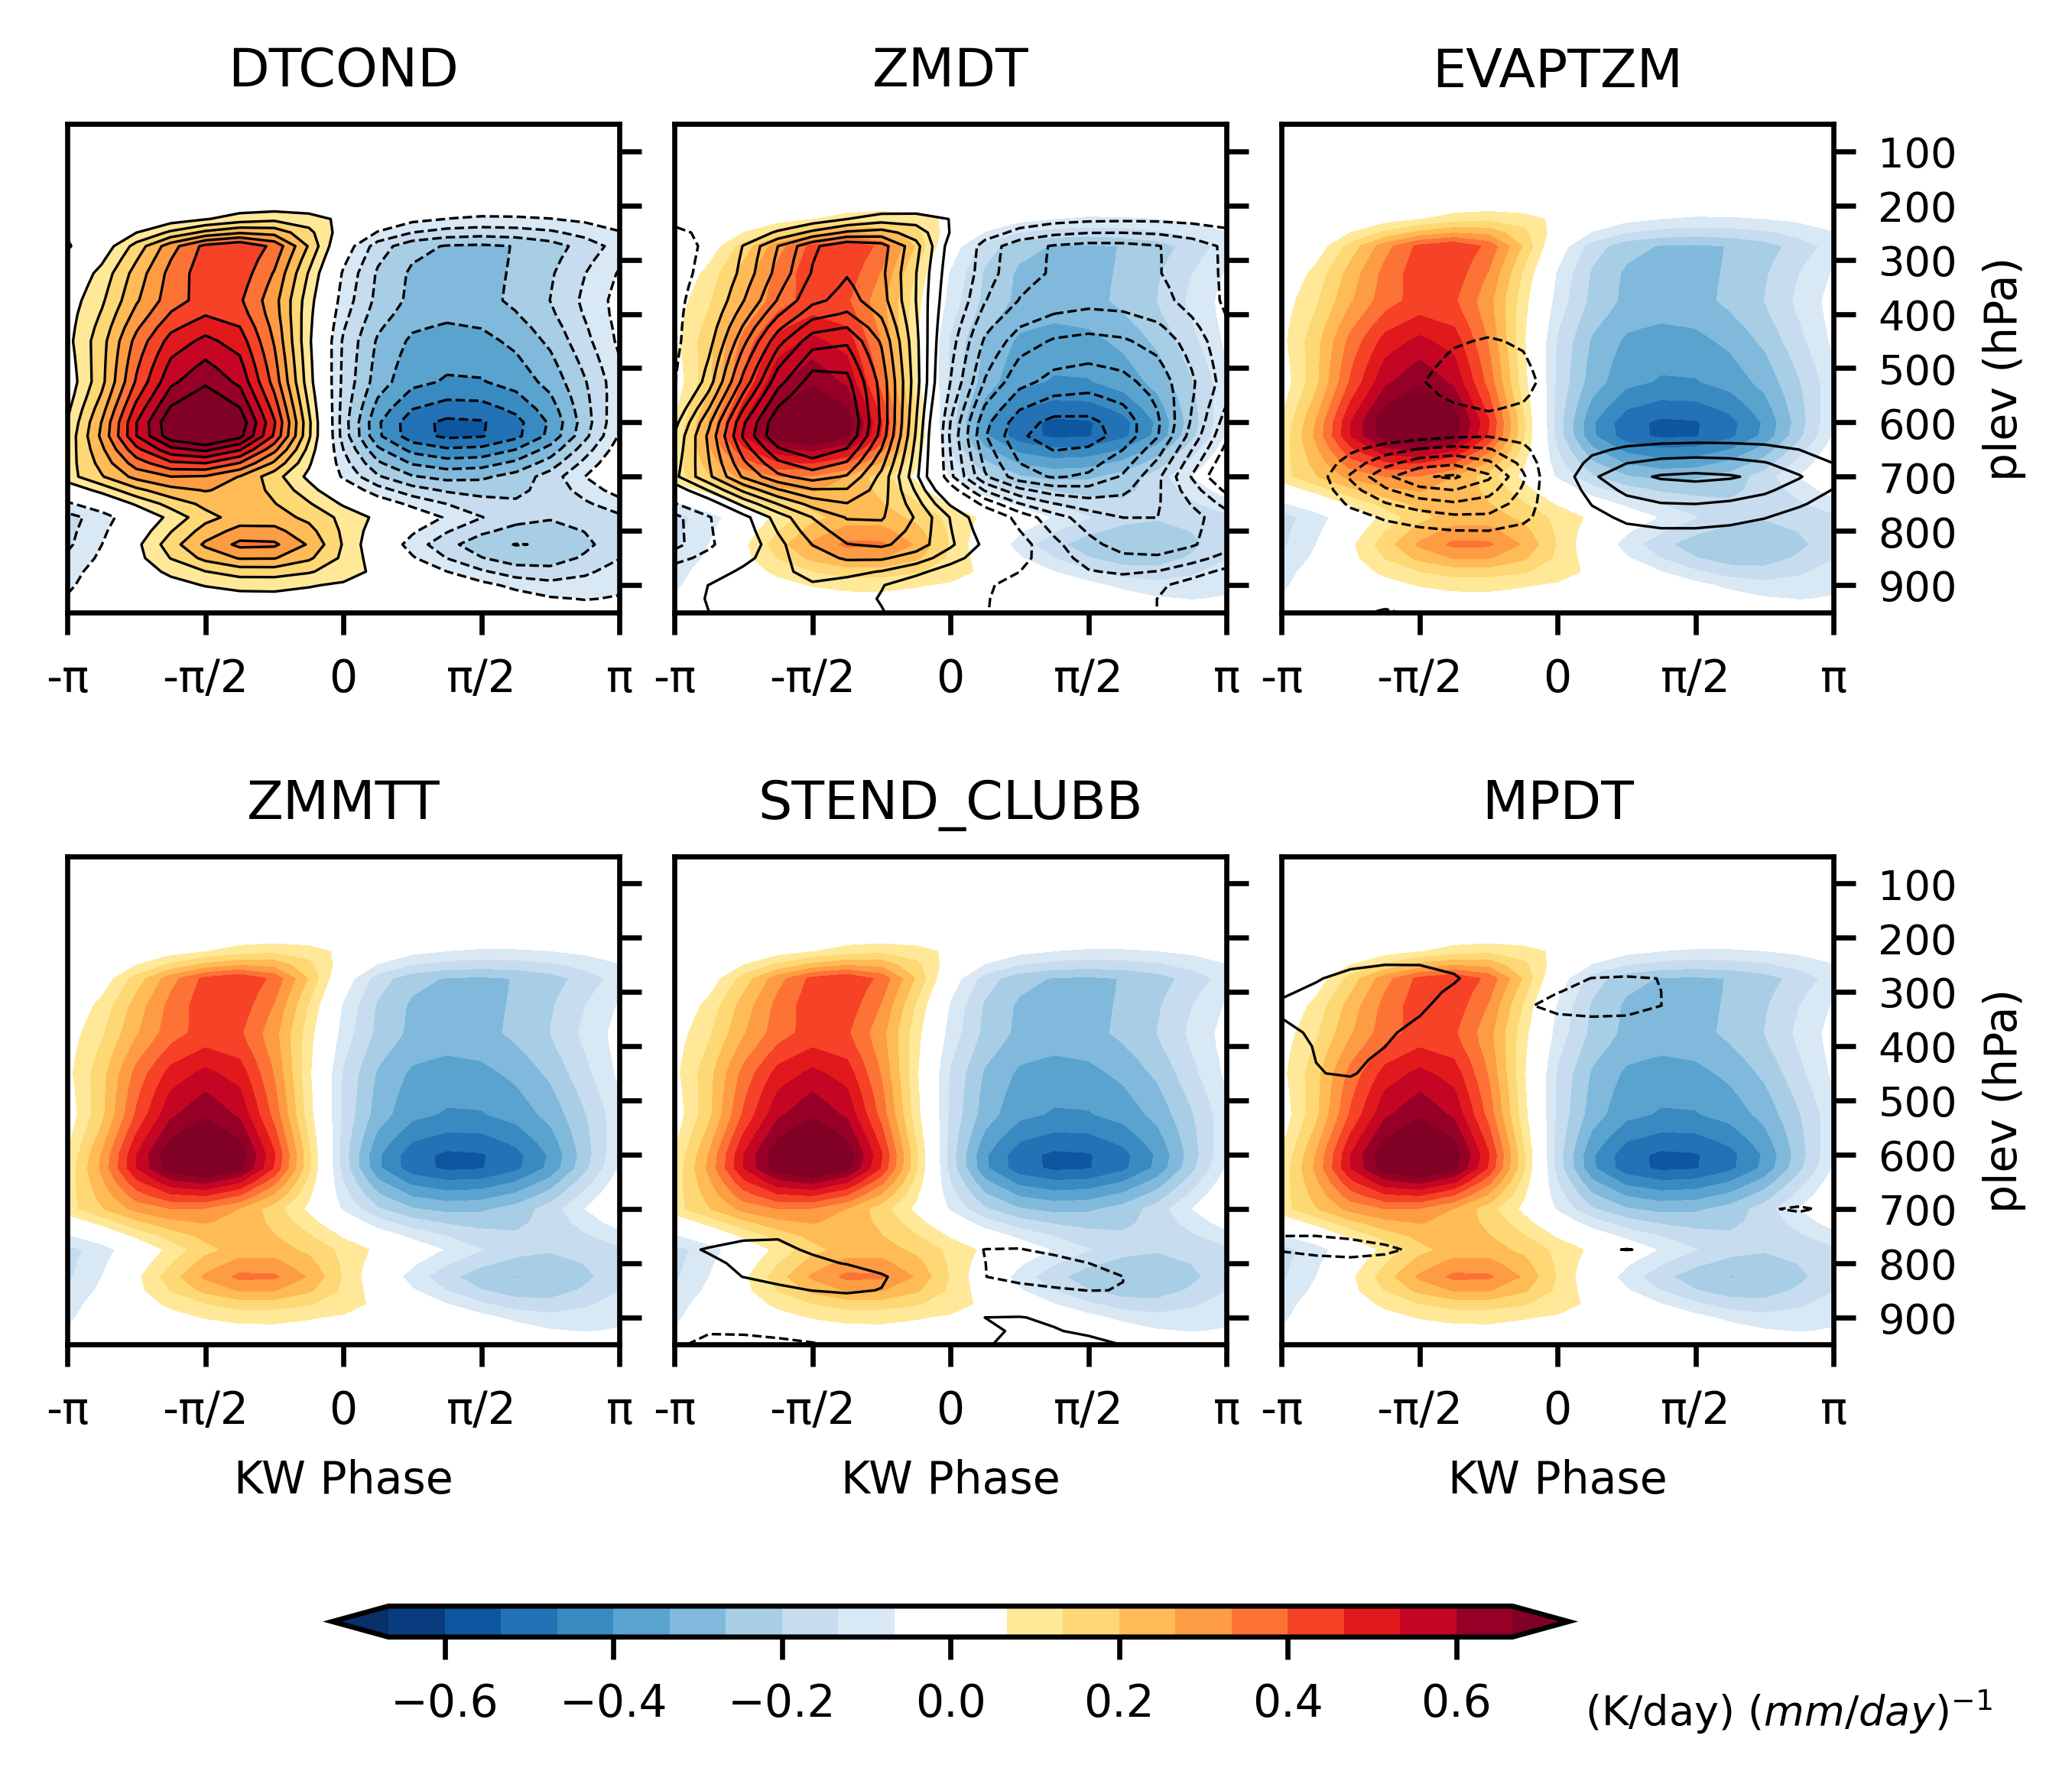

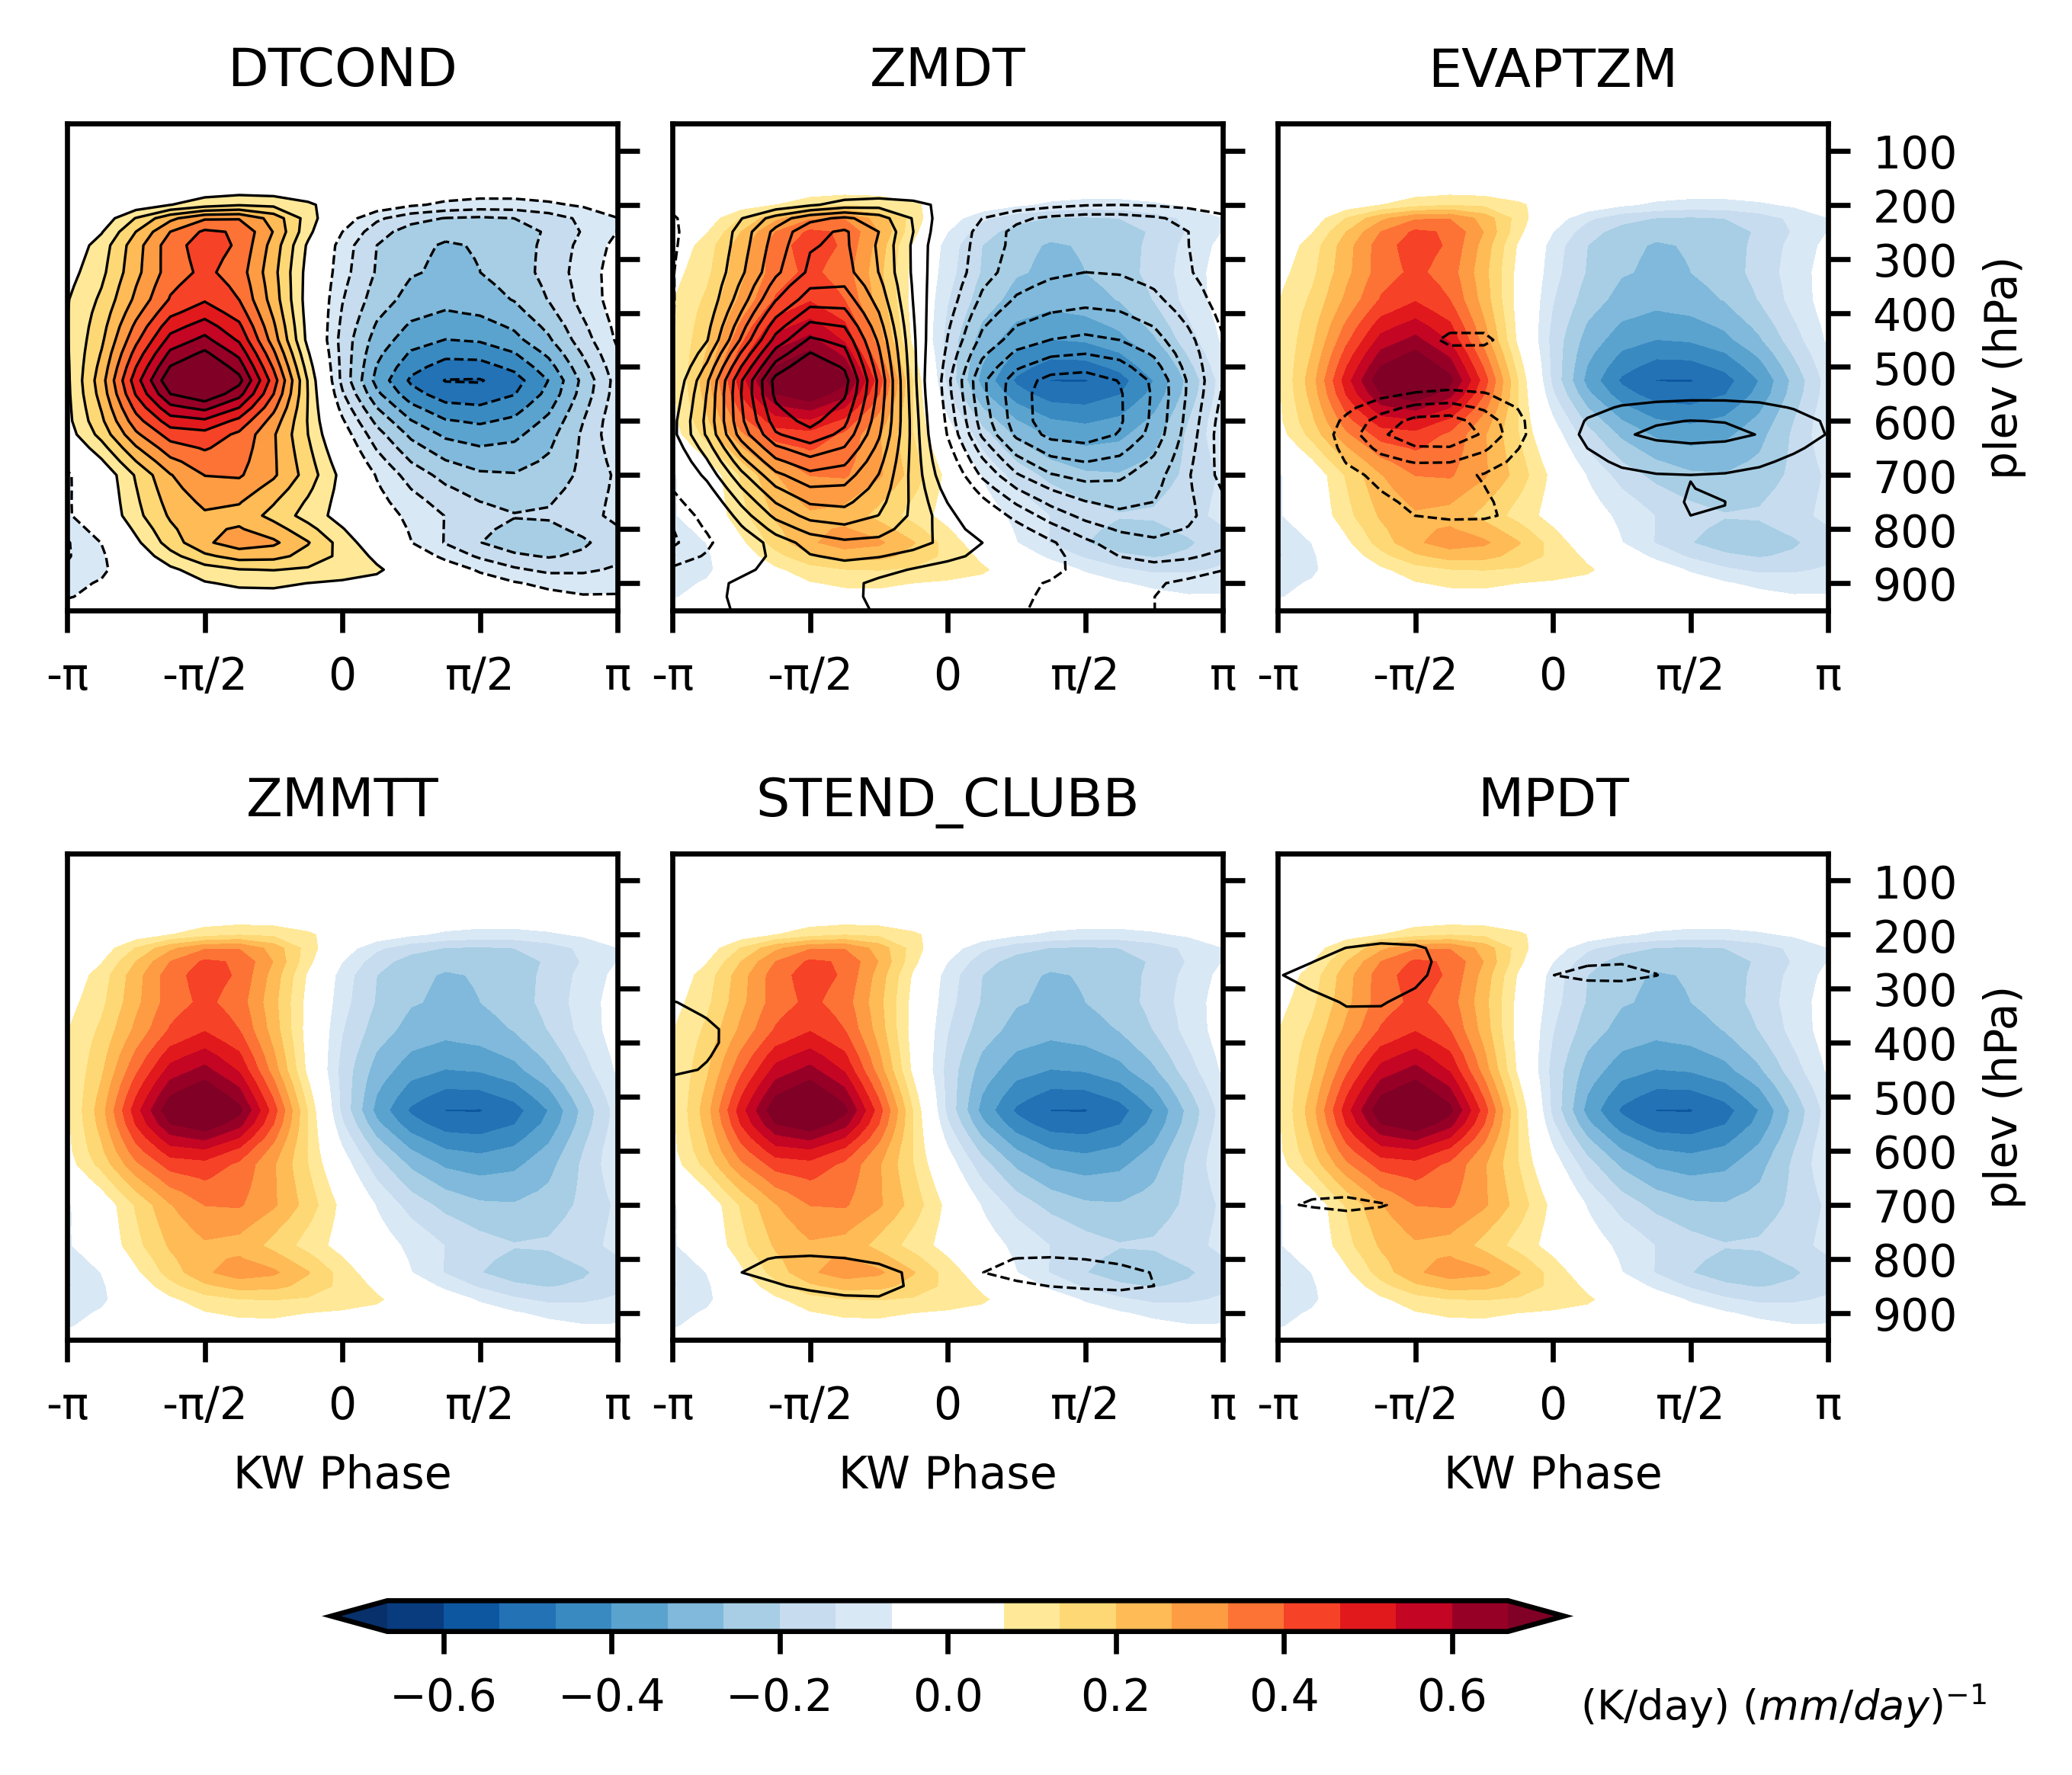

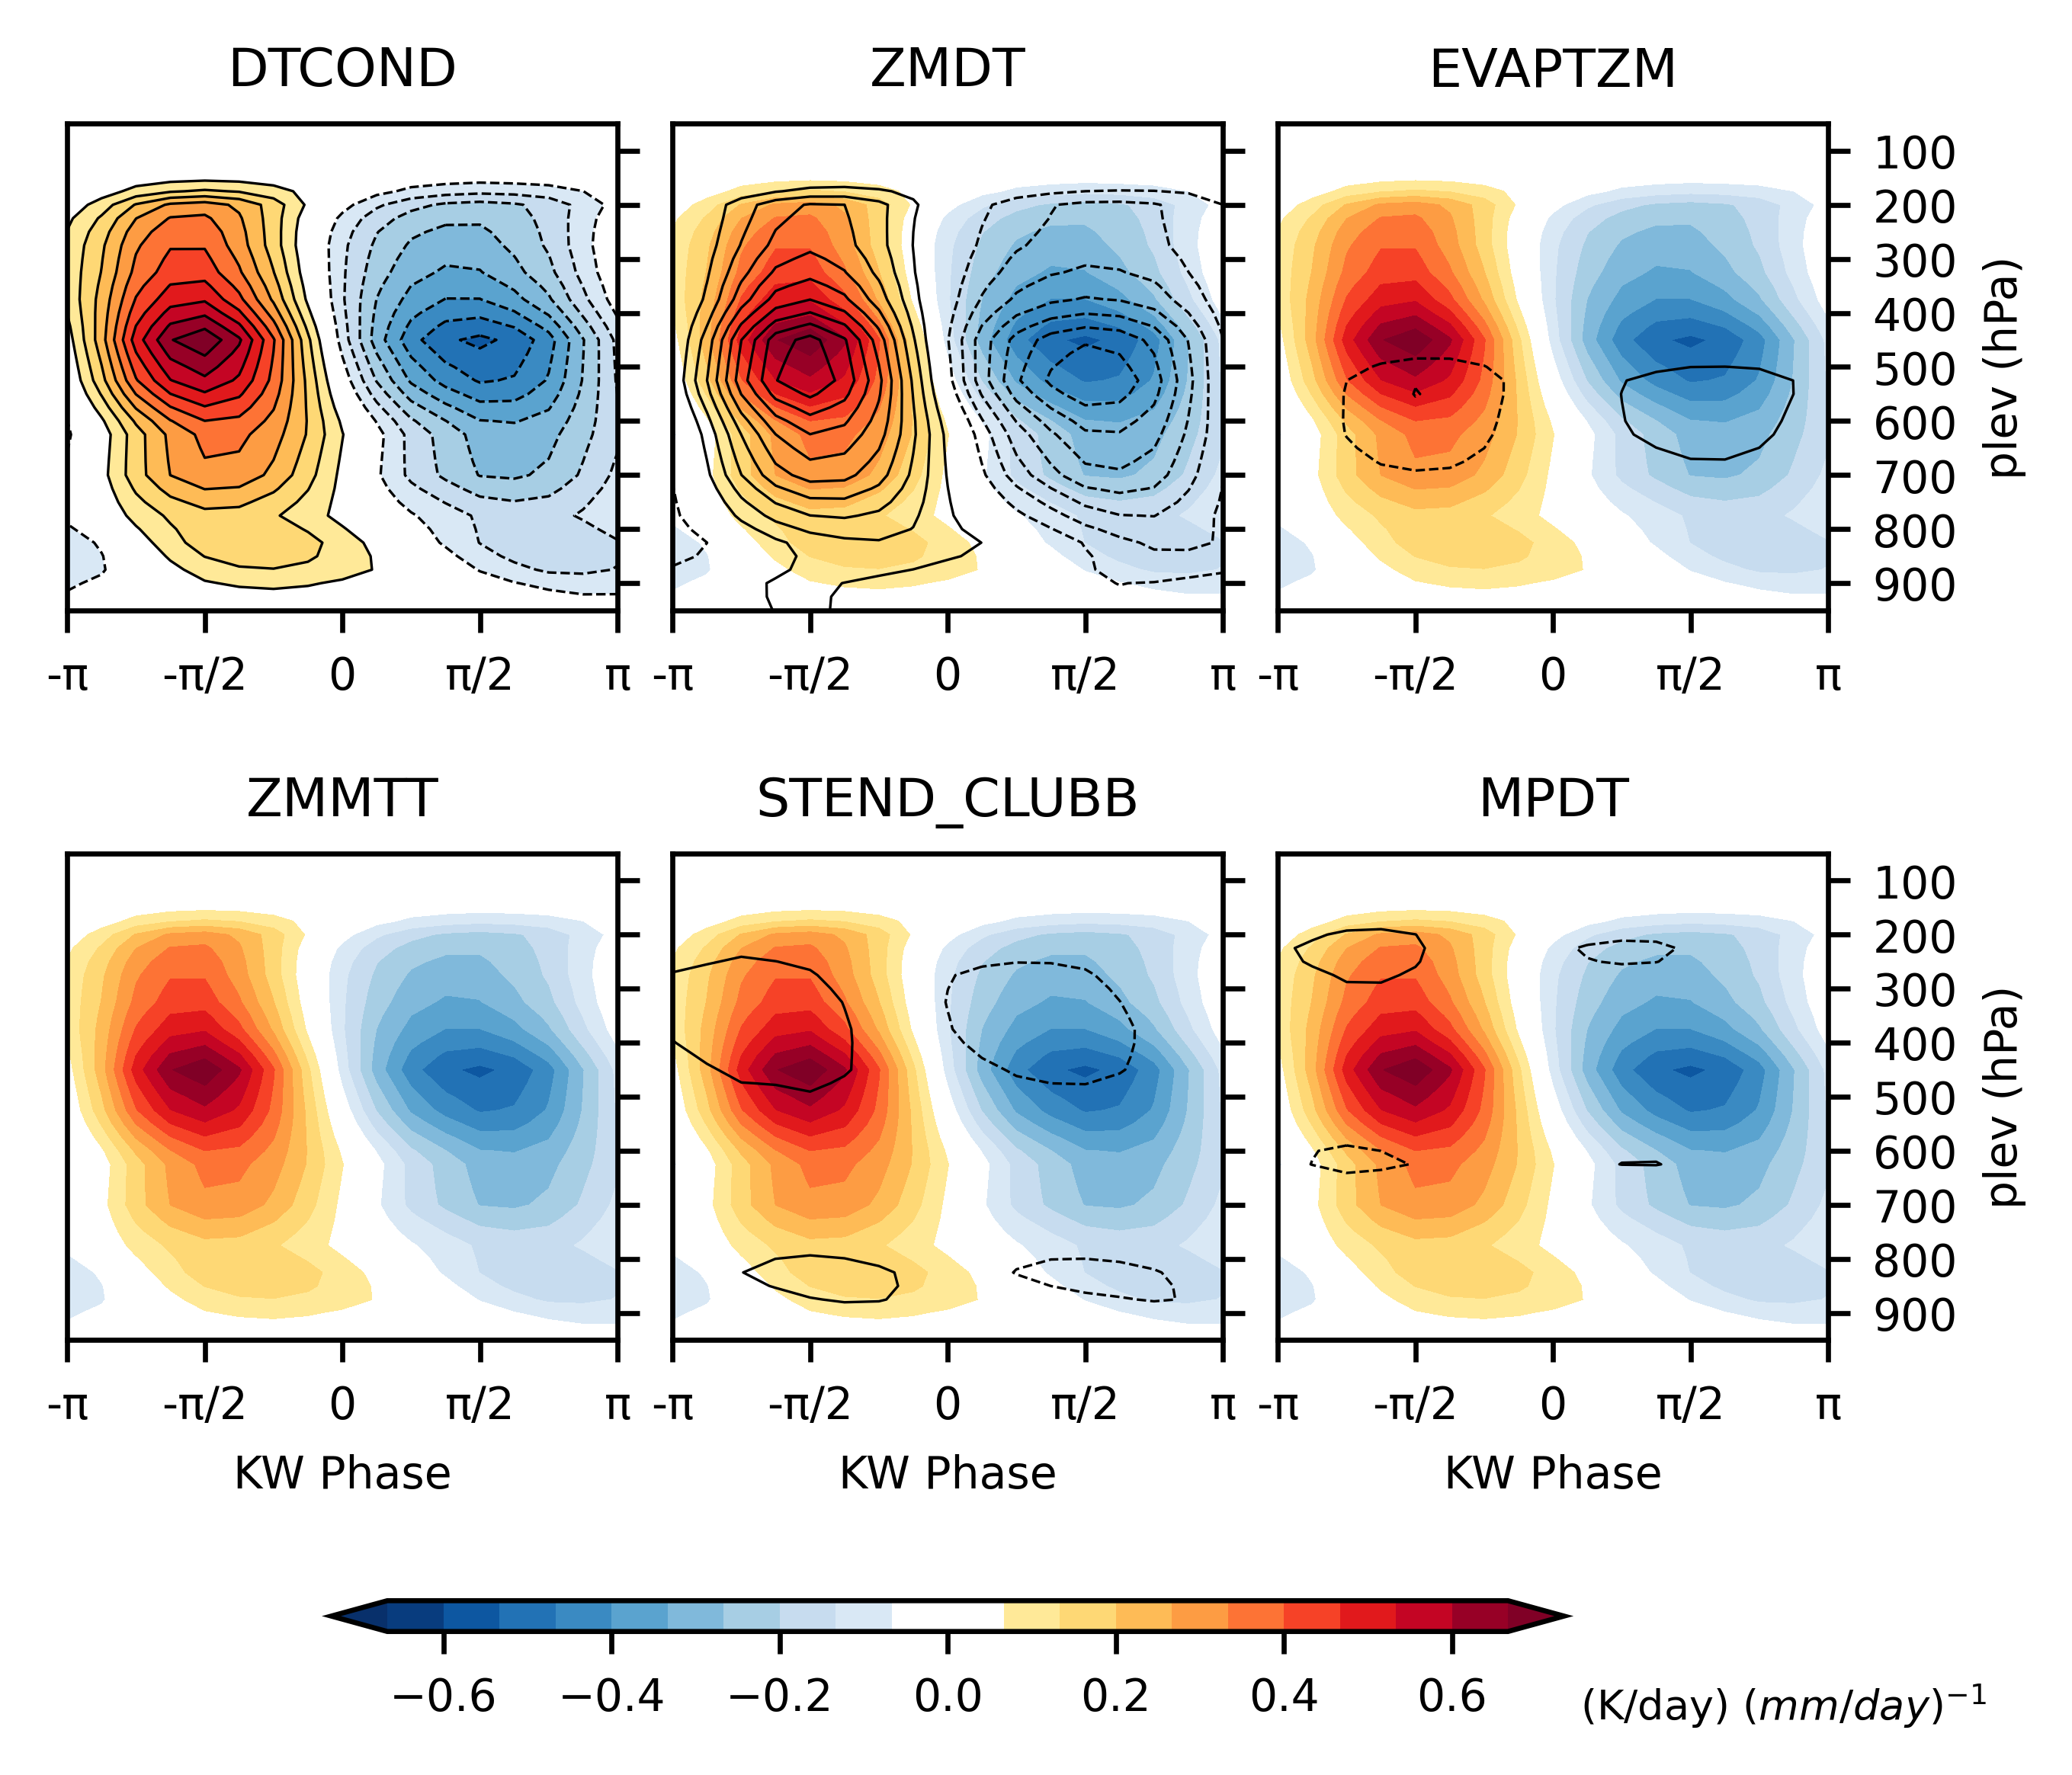

In [41]:
##################################
# Plot Fig. S5: KW composite vertical structure of each temperature tendency term
#############################
normalize_by_kwamp = 1
vname_temp_tendency = list(['DTCOND','ZMDT','EVAPTZM','ZMMTT','STEND_CLUBB','MPDT'])
font = 7

clev_n = np.arange(-2,0,0.2)/3
clev_p = np.arange(0.2,2.2,0.2)/3
clev   = np.arange(-2,2.2,0.2)/3
xx, yy = np.meshgrid(phase, plev)

for icase in range(0,3):
    fig,axes = plt.subplots(2,3,figsize=(5.5, 4),dpi=600)
    plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.5,wspace=0.1)
    plt.rcParams.update({'font.size': font})
    for iplt in range(0,6):
        plt.subplot(2,3,iplt+1)
        ax = plt.gca()
        VAR_cn = globals() [vname_temp_tendency[iplt]+'_KW']
        VAR_cf = globals() [vname_temp_tendency[0]+'_KW'] # Q total
        if normalize_by_kwamp == 1:
            VAR_cn = VAR_cn[:,:,icase]/kwamp_all[icase]
            VAR_cf = VAR_cf[:,:,icase]/kwamp_all[icase]
        cf   = plt.contourf(xx, yy, VAR_cf.T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, VAR_cn.T, levels=clev_p, colors='k', linewidths=0.4)
        #cn_0 = plt.contour(xx, yy, VAR_cn.T, levels=clev_0, colors='g', linewidths=1.2)
        cn_n = plt.contour(xx, yy, VAR_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([50,950])
        #plt.ylim([np.min(plev), np.max(plev)])
        plt.title(vname_temp_tendency[iplt])
        plt.yticks(np.arange(100,1000,100))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        ax.yaxis.set_label_position("right")
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        if iplt == 2 or iplt == 5:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=True)
            ax.set_ylabel('plev (hPa)',fontsize=font)
        else:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)       
    
        if iplt > 2:
            plt.xlabel('KW Phase',fontsize=font)
    
    cb = plt.colorbar(cf,ax=axes,orientation = 'horizontal', shrink=.7, aspect=40,pad=0.15) 
    ax.text(0.55, -0.8, '(K/day) $(mm/day)^{-1}$',\
                    verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,\
                    color='k', fontsize=6.5)
    plt.savefig(figdir+'Fig.S5_dTdt_KW_'+CASENAME_SHORT_LIST[icase]+'.png',dpi=600)
    plt.show()
    plt.close()